# ROC Analysis on BayesDel data

This notebook includes the code for completing ROC analysis on BayesDel data.

Some of the code was actually taken from the 1st paper linked in the project briefing, where they investigated fumarate hydratase. That's available in this link here -> https://github.com/shorthouse-mrc/Fumarate_Hydratase.

10.02.2025 - To be honest this was much more difficult than I expected. I spent lots of Sunday and Monday trying to figure out how to do this. Most of Sunday was spent trying to understand the Calculate gene.ipynb notebook thinking I needed to apply the code from that to here. After spending hours trying to find my way around how to generate .area files I realised I could consult the project briefing for some help and it provided me with the Github link above. Then I proceeded to spend the entirety of Monday working my way around the Github code trying to see what files I needed and how I could do it. It was really hard. I don't think I should have struggled this much. But as a result I don't feel too confident about what I've done and I'm not quite sure if I've done the right thing. Nevertheless I gave it a shot and hopefully there's quite a few good points.

### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

## Extracting calculated properties data
There are quite a few datasets available which we could use for fumarate hydratase. The one used in the project briefing paper is the LOVD (Leiden Open Variation Database) [1]. That and a few other datasets can be found in this link -> https://grenada.lumc.nl/LSDB_list/lsdbs/FH. Another database is ClinVar which looks like it has more information but it has a lower rating. So the database is likely less accurate. There is also the Human Gene Mutation Database (HGMD) which is a very large database of mutations, but you will need to make an account to access it.

Perhaps a place which we can explore in are these different databases. In my opinion we should not worry about them at the moment because there's already quite a bit to do as currently is.

Reference: 

[1] Bayley, JP., Launonen, V. & Tomlinson, I.P. The FH mutation database: an online database of fumarate hydratase mutations involved in the MCUL (HLRCC) tumor syndrome and congenital fumarase deficiency. BMC Med Genet 9, 20 (2008). https://doi.org/10.1186/1471-2350-9-20 

In the code cell below I have taken the `FH_complete_mutation_summary.csv` file from the Github link which was provided in the first paper in the project briefing -> https://github.com/shorthouse-mrc/Fumarate_Hydratase/tree/master.

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


It's probably useful to list all the definitions of these columns.

| **Column Name**          | **Description** |
|-------------------------|----------------|
| `Unnamed: 0` | Indexing |
| `Residue` | **Location** of the amino acid. |
| `AAfrom` | The amino acid we are mutating **from**. |
| `AAto` | The amino acid we are mutating **to**. |
| `rhapsodyscore` | A numerical score produced by Rhapsody to predict the stability effect of a mutation on a protein. |
| `rhapsodyclass` | Classification of Rhapsody predictions into 'neutral' or 'deleterious' types of mutations. |
| `polyphenscore` | A numerical score produced by Polyphen to predict the structural effect of a mutation on a protein. |
| `polyphenclass` | Classification of Polyphen predictions into 'neutral' or 'deleterious' types of mutations. |
| `Foldx_energy` | The change in free energy calculated by the FoldX program. |
| `Rosetta_energy` | The change in free energy calculated by the Rosetta program. |
| `Mutation` | Amino acid mutating from - residue - amino acid mutating to. |
| `average_energy` | Likely the average energy between the FoldX and Rosetta models. |
| `RSA` | How exposed our residue is to water. |
| `Mindist_bindingsiteA` | The minimum distance from the amino acid at that residue to the binding site A. |
| `Mindist_hinge` | The minimum distance from the amino acid at that residue to a hinge region of the protein. |

As we are taking a look at BayesDel and REVEL data, not Polyphen and Rhapsody scores, I'm going to remove those columns from our table. They'll still be kept in the .csv file document incase they are needed.

In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


**Questions I've got:**
- Is `FH_complete_mutation_summary.csv` actually the file that we'd like to use for our calculated components? Intuitively I'd think so but I just want to make sure.
- In the table above, the `Foldx_energy` and `Rosetta_energy` columns have completely different energies despite the same mutation at the same residue. As far as I know those two energies represent the same thing, but they are just calculated using different models (There's more information on the third reference in the project briefing). What have I done wrong for there to be a discrepancy here?

## Extracting BayesDel data
Now we will take our BayesDel data which I've labelled as `BayesDel` below for convenience. Big thank you to Keyu for the data.

In [4]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

In [5]:
# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

BayesDel.head()

,#chr,pos(1-based),ref,alt,genename,rs_dbSNP,AAfrom,AAto,Residue,HGVSc_VEP,HGVSp_VEP,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,1,241497828,T,A,FH,.,X,C,511,c.1533A>T,p.Ter511CysextTer3,0.016367,-0.214267,0.53578
1,1,241497828,T,C,FH,.,X,W,511,c.1533A>G,p.Ter511TrpextTer3,0.048540,-0.168052,0.57861
2,1,241497828,T,G,FH,.,X,C,511,c.1533A>C,p.Ter511CysextTer3,0.019965,-0.209098,0.54067
3,1,241497829,C,A,FH,.,X,L,511,c.1532G>T,p.Ter511LeuextTer3,-0.136883,-0.434399,0.30031
4,1,241497829,C,G,FH,rs2147911168,X,S,511,c.1532G>C,p.Ter511SerextTer3,-0.148895,-0.451654,0.28133


In [6]:
# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

In [7]:
BayesDel.head()

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,X,C,511,0.016367,-0.214267,0.53578
1,X,W,511,0.048540,-0.168052,0.57861
2,X,C,511,0.019965,-0.209098,0.54067
3,X,L,511,-0.136883,-0.434399,0.30031
4,X,S,511,-0.148895,-0.451654,0.28133


In [8]:
BayesDel_benign = BayesDel[BayesDel['BayesDel_noAF_score'] < -0.057]
BayesDel_deleterious = BayesDel[BayesDel['BayesDel_noAF_score'] >= -0.057]

In [9]:
# converting tables to string to avoid potential errors
calculatedProperties = calculatedProperties.astype(str)
BayesDel_benign = BayesDel_benign.astype(str)
BayesDel_deleterious = BayesDel_deleterious.astype(str)

In [10]:
# merging datasets to get ready for binary classification
bs_calc = BayesDel_benign.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])
ds_calc = BayesDel_deleterious.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [11]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [12]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
0,L,V,507,0.125399,-0.0576501,0.66673,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
1,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
2,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
3,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
4,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1,0
2720,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
2721,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
2722,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In [13]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

## ROC Curve: FoldX energy

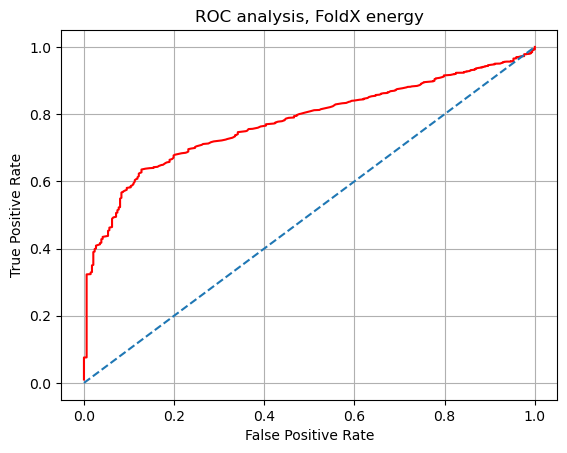

In [14]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["Foldx_energy"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, FoldX energy")

plt.grid()
plt.show()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
606,1.06,0.127596,0.635095,0.753750
607,1.07,0.127596,0.631791,0.752098
608,1.08,0.127596,0.629222,0.750813


So it seems like the best threshold for the Fold X energy obtained here is 1 kcal/mol. That's interesting, because the cutoff which had been used in the 1st paper in the project briefing had a cutoff of 2.5 kcal/mol. So there seems to be a discrepancy there. Although it feels like I've spent most of the notebook ranting about why I might be wrong, something surprising is that the area underneath the curve is about 76%. Whilst not an ideal binary classification model, it's certainly not the worst one either. So that indicates that I have at least got one thing right which is good to know.

## ROC Curve: Rosetta energy

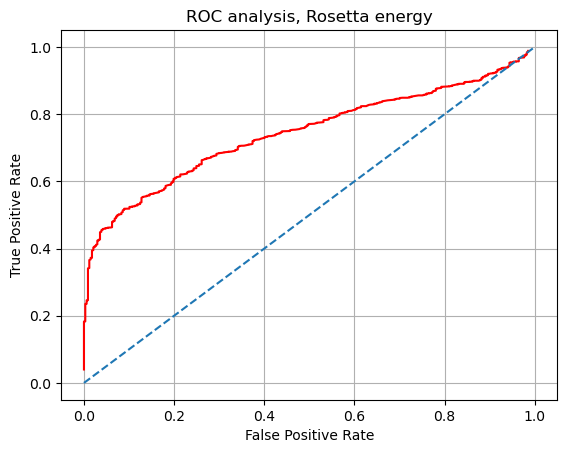

In [16]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["Rosetta_energy"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Rosetta energy")

plt.grid()
plt.show()

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
837,3.37,0.089021,0.518355,0.714667
838,3.38,0.089021,0.517988,0.714484
844,3.44,0.086053,0.513950,0.713948


## ROC Curve: Average energy

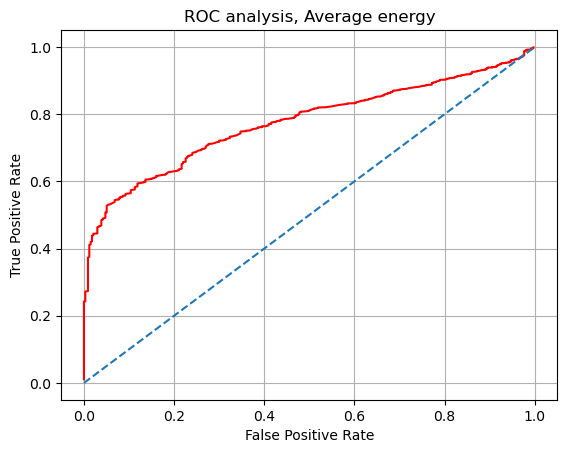

In [18]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["average_energy"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Average energy")

plt.grid()
plt.show()

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
740,2.40,0.050445,0.527533,0.738544
739,2.39,0.053412,0.530103,0.738345
741,2.41,0.050445,0.526799,0.738177


I had a smile on my face when I saw that the best cutoff threshold here was at 2.4 kcal/mol, corresponding to an AUC of 75.3. Ideally we would like to get over 80%.

## ROC Curve: Minimum distance to binding site A
In the code below I'm going to change something.

Previously I had a line `predvalue = 1 if item >= i else 0`. What that means is, if our mechanistic model score we are looking at is greater than a certain value, we say that predicts the mutation is deleterious. If it is smaller than a certain value, it's benign.

We can understand why we do this by going back to the definitions of the energies. These energies represent the change in energy from the normal protein to the mutated protein. So intuitively it would make sense that the higher this change in energy is, the more likely it is that the mutation impacts the functionality of the protein. Hence, higher energies would correspond to deleterious mutations.

However this is not quite the same for `Mindist_bindingsiteA`. That variable represents the minimum distance between our residue of interest to a binding site A. The binding site is very important for the functionality of the protein. If an amino acid which is very close to a binding site mutates, it is more likely that mutation will impact the functionality of the protein. In contrast, an amino acid further away from a binding site is less likely to impact the functionality of the protein.

Thus, the lower the score of `Mindist_bindingsiteA` is, the more likely that mutation represents something deleterious. Hence, we'll need to amend that classification line to ` predvalue = 1 if item <= i else 0`. 

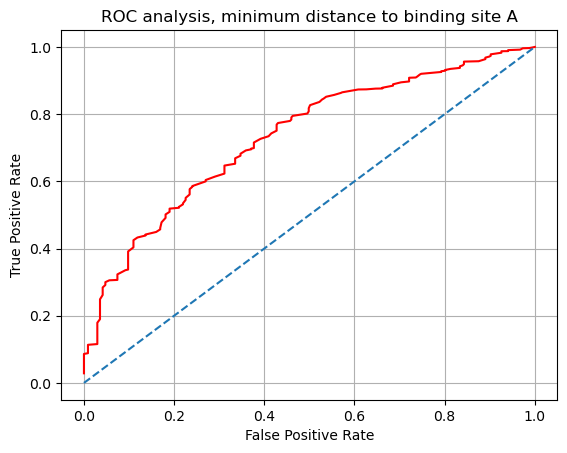

In [20]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_bindingsiteA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, minimum distance to binding site A")

plt.grid()
plt.show()

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
148,14.8,0.240356,0.585903,0.672774
147,14.7,0.240356,0.583700,0.671672
179,17.9,0.430267,0.773495,0.671614


So whilst not entirely accurate, the minimum distances to the binding site are still predicting the pathogenicity better than a random guessing model.

## ROC Curve: Minimum distance to hinge site

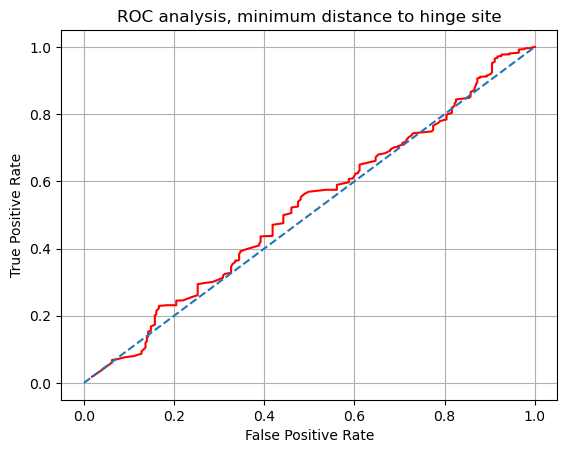

In [22]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_hinge"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, minimum distance to hinge site")

plt.grid()
plt.show()

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
161,16.1,0.489614,0.563142,0.536764
159,15.9,0.480712,0.552863,0.536076
160,16.0,0.480712,0.552863,0.536076


This one is really odd. The closer we are to a hinge site, surely the more likely it is that our mutation is deleterious? Despite this, the classification is only doing about as good as a random guesser. That's really against intuition, at least with my limited knowledge.

An idea I have is to multiply these two metrics together. Maybe the two combined will do a better job at predicting the pathogenicity of mutations.

## ROC Curve: RSA

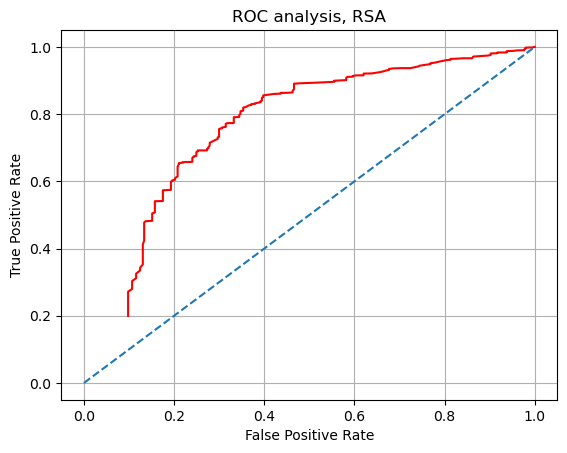

In [24]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,1, 0.001):
    pred = []
    for item in plotting_frame["RSA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, RSA")

plt.grid()
plt.show()

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
356,0.356,0.353116,0.819383,0.733134
355,0.355,0.353116,0.819383,0.733134
354,0.354,0.353116,0.819383,0.733134


I'm assuming this has something to do with hydrophobicity... but someone needs to help me with this one.

# Looking at alternative metrics

So we determined that the best cutoff for the average energy is 2.4 kcal/mol. What does this mean? For an average folding energy which is greater than 2.4 kcal/mol, our mutation can be classified as deleterious. Because its change in free energy in comparison to its regular energy will be much higher than it should be.

Our `ds_calc` is the list of all mutations which had BayesDel scores greater than a certain threshold value. So that table is the list of 'deleterious' mutations classed according to BayesDel.

I'm planning on using quite a lot of the code from Hypothesis testing.ipynb

### FoldX energies
Let's go through what the code below is doing.

`ds_calc_nofold = ds_calc[ds_calc["Foldx_energy"].astype(float)<=cutoff]`: when the FoldX energy of any entry in `ds_calc` is less than or equal to our threshold value, we keep it in our deleterious mutations array. In other words, we remove all of the deleterious mutations for which our FoldX energy is greater than the threshold value.

This basically gives us the deleterious mutations which according to the statistical scores are deleterious, but according to the mechanistic scores not deleterious. We could think of it as the 'fraction which disagrees'.

In our binary classification model, we played around with `source_deleterious`. This was equal to 1 for deleterious mutations and 0 for non-deleterious mutations. Because we've chosen to do it like this, our deleterious mutations indicate our positive results. As we've taken all of the deleterious mutations which do not agree, `ds_calc_nofold` will be our **false positive**.

`bs_calc_nofold = bs_calc[bs_calc["Foldx_energy"].astype(float)<=cutoff]` does mostly the same thing. The only difference is that this time our `bs_calc_nofold` will be our **true negative**. Negative, because our deleterious one-hot encoding corresponds to positive. Thus benign must be our negative. True, because remember, the lower the energy is, the more likely it is our mutation is benign. We are keeping all of the mutations which have a FoldX energy lower than the threshold.

Then the **true positive** would just be the difference between all positive and false positives, and the **false negative** will also be the difference between all negatives and true negatives.

We print out the accuracy, sensitivity and specificity. Although I find it easier to just look at the FP, TP etc values on their own.

In [26]:
cutoff= 1.06 # best threshold for FoldX as found by ROC AUC

ds_calc_nofold = ds_calc[ds_calc["Foldx_energy"].astype(float)<=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_nofold = bs_calc[bs_calc["Foldx_energy"].astype(float)<=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_nofold) # cases correctly classified as benign
FP = len(ds_calc_nofold) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Percentage of deleterious cases correctly classified:", TP*100/(TP+FP),"%")

print(" ")

print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)
print("Percentage of benign cases correctly classified:", TN*100/(TN+FN),"%")

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.6612218229336818
Sensitivity: 0.975747320924986
Specificity: 0.22826086956521738
 
Amount of deleterious cases incorrectly classified: 994
Amount of deleterious cases correctly classified: 1730
Percentage of deleterious cases correctly classified: 63.50954478707783 %
 
Amount of benign cases falsely classified: 43
Amount of benign cases correctly classified: 294
Percentage of benign cases correctly classified: 87.24035608308606 %


What we see is that the general accuracy is quite bad, at 66%. That's also a bit lower than our auc which was about 73%. We can also see that although the model seems to be quite good at classifying benign cases, it's not as good as classifying deleterious ones. I have tried messing around with the cutoff already but I'll speak about it in a bit.

### Rosetta energies

In [27]:
cutoff= 3.37

ds_calc_norosetta = ds_calc[ds_calc["Rosetta_energy"].astype(float)<=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_norosetta = bs_calc[bs_calc["Rosetta_energy"].astype(float)<=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_norosetta) # cases correctly classified as benign
FP = len(ds_calc_norosetta) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Percentage of deleterious cases correctly classified:", TP*100/(TP+FP),"%")

print(" ")

print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)
print("Percentage of benign cases correctly classified:", TN*100/(TN+FN),"%")

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.5615811826200588
Sensitivity: 0.9791955617198336
Specificity: 0.18962322421247685
 
Amount of deleterious cases incorrectly classified: 1312
Amount of deleterious cases correctly classified: 1412
Percentage of deleterious cases correctly classified: 51.83553597650514 %
 
Amount of benign cases falsely classified: 30
Amount of benign cases correctly classified: 307
Percentage of benign cases correctly classified: 91.0979228486647 %


It's quite clear here that Rosetta energies have more false positives than the FoldX energies do. This is bolstered by the fact that the auc for FoldX is at 75.3, whereas it's at about 71 for Rosetta. That would suggest that FoldX is a better means of classifying our energies. 

~~It's quite interesting that this has happened. Because when we calculate the Rosetta energy, we use 'ensemble-based methods', i.e. we incorporate dynamics. This is something which we don't include in FoldX calculations. This appears counter-intuitive. Why does Rosetta have lower accuracies?~~ The Rosetta and FoldX energies are completely different in the first place so they must represent different things, unless something terribly wrong has happened in their initial calculations

### Average energies

In [28]:
cutoff= 2.4

ds_calc_noavg = ds_calc[ds_calc["average_energy"].astype(float)<=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_noavg = bs_calc[bs_calc["average_energy"].astype(float)<=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_noavg) # cases correctly classified as benign
FP = len(ds_calc_noavg) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Percentage of deleterious cases correctly classified:", TP*100/(TP+FP),"%")

print(" ")

print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)
print("Percentage of benign cases correctly classified:", TN*100/(TN+FN),"%")

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.5739954263312643
Sensitivity: 0.9883081155433288
Specificity: 0.19912881144990666
 
Amount of deleterious cases incorrectly classified: 1287
Amount of deleterious cases correctly classified: 1437
Percentage of deleterious cases correctly classified: 52.75330396475771 %
 
Amount of benign cases falsely classified: 17
Amount of benign cases correctly classified: 320
Percentage of benign cases correctly classified: 94.95548961424332 %


If this markdown cell reads a bit off it's because I actually looked at `average_energy` first

So 95% of the mutations which were classed as benign according to our BayesDel scores will also be classed as benign according to our `average_energy` cutoff value. However, only half of the mutations which were classed as deleterious according to BayesDel are also classed as deleterious according to our `average_energy`. Similar with the other two.

That would suggest to me that our mechanistic models agree a lot with predictions of benign mutations. However, there does not seem to be as much of an agreement when it comes to deleterious mutations. Only about half of them agree. The fact that the model agrees with benign but not with deleterious may suggest two things. Either I've classified the deleterious mutations incorrectly (may need to use a higher threshold, not -0.057). Or there's a 'gray area' where it's impossible to classify our mutation as deleterious, but we know it can't be benign either.

Previously I had used a threshold of -0.057. Below this I classed them as benign and above this as deleterious. If I increase the deleterious threshold, say to like 0.3, then the fraction of `average_energy` which agrees increases. However by doing this I'm leaving out some mutation data. So this would not be a good approach.

Alternatively I could increase both thresholds until I reach a very good value of both deleterious and benign remaining, but it looks like the two will only level off to about 67%. But even when I do that, I'm lowering the auc.

---

Afterwards I also took the code for accuracy, sensitivity and specificity from the `Hypothesis testing.ipynb` notebook. These accuracies are not good. I decided to mess around with the cutoffs a bit and found something really not right. When I decrease the cutoff I get an increased accuracy. That's odd...

Specifically when I decrease the cutoff to 0.1 (way below the threshold), I'm classifying more deleterious cases correctly. But I'm classifying less benign cases correctly.

Conversely when I increase my cutoff to 10 I'm classifying most of my deleterious cases incorrectly but most of my benign cases are correctly classified.

### Minimum distance to binding site

In [29]:
cutoff= 14.8

ds_calc_nobinding = ds_calc[ds_calc["Mindist_bindingsiteA"].astype(float)>=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_nobinding = bs_calc[bs_calc["Mindist_bindingsiteA"].astype(float)>=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_nobinding) # cases correctly classified as benign
FP = len(ds_calc_nobinding) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Percentage of deleterious cases correctly classified:", TP*100/(TP+FP),"%")

print(" ")

print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)
print("Percentage of benign cases correctly classified:", TN*100/(TN+FN),"%")

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.6050310356092781
Sensitivity: 0.9516994633273703
Specificity: 0.18497109826589594
 
Amount of deleterious cases incorrectly classified: 1128
Amount of deleterious cases correctly classified: 1596
Percentage of deleterious cases correctly classified: 58.590308370044056 %
 
Amount of benign cases falsely classified: 81
Amount of benign cases correctly classified: 256
Percentage of benign cases correctly classified: 75.96439169139465 %


### Minimum distance to hinge site

In [30]:
cutoff= 16.1

ds_calc_nohinge = ds_calc[ds_calc["Mindist_hinge"].astype(float)>=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_nohinge = bs_calc[bs_calc["Mindist_hinge"].astype(float)>=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_nohinge) # cases correctly classified as benign
FP = len(ds_calc_nohinge) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Percentage of deleterious cases correctly classified:", TP*100/(TP+FP),"%")

print(" ")

print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)
print("Percentage of benign cases correctly classified:", TN*100/(TN+FN),"%")

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.5573342045083306
Sensitivity: 0.9028840494408475
Specificity: 0.1262848751835536
 
Amount of deleterious cases incorrectly classified: 1190
Amount of deleterious cases correctly classified: 1534
Percentage of deleterious cases correctly classified: 56.31424375917768 %
 
Amount of benign cases falsely classified: 165
Amount of benign cases correctly classified: 172
Percentage of benign cases correctly classified: 51.038575667655785 %


This one had the lowest auc so I guess it's not so surprising to see that it has the lowest accuracy. Also has the lowest proportion of getting classifications correct.

### RSA

In [31]:
cutoff= 0.356

ds_calc_norsa = ds_calc[ds_calc["RSA"].astype(float)>=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_norsa = bs_calc[bs_calc["RSA"].astype(float)>=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_norsa) # cases correctly classified as benign
FP = len(ds_calc_norsa) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Percentage of deleterious cases correctly classified:", TP*100/(TP+FP),"%")

print(" ")

print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)
print("Percentage of benign cases correctly classified:", TN*100/(TN+FN),"%")

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.8003920287487749
Sensitivity: 0.9493832411739686
Specificity: 0.30704225352112674
 
Amount of deleterious cases incorrectly classified: 492
Amount of deleterious cases correctly classified: 2232
Percentage of deleterious cases correctly classified: 81.93832599118943 %
 
Amount of benign cases falsely classified: 119
Amount of benign cases correctly classified: 218
Percentage of benign cases correctly classified: 64.68842729970326 %


---

I'm in disbelief. That can't be correct... 

This looks way too good to be true. I might have made a mistake somewhere. It doesn't make sense to me that the RSA has an 80% accuracy in predicting benign and deleterious cases. Whilst all the others barely reach 60% if at all. Its positives and negatives seem to match the accuracy. It also has a decently high auc. This is really surprising.

So based on these performances, surely the RSA blows all other mechanistic models out of the water? While good, its auc value isn't extraordinary. It gets beaten by `average_energy` and FoldX I believe. So that's really odd.

~~I'm going to take a look at making predictions from alternative metrics once I exclude single metrics. Of course if I did this every time I'd have lots and lots of plots, which would overwhelm everyone. So I'm only going to exclude two metrics, `FoldX_energy` and `RSA`. What do I mean by excluding? Basically what we've done in the code above. Exclude some data based on their `FoldX_energy` values then re-run the logistic regression and ROC analysis having excluded `FoldX_energy` from our plotting frame.~~

### We could try to plot the failed predictions.
I could do RSA vs residue or RSA vs fold energy? Since those were my two most accurate parameters.

In [32]:
# Get our readings which aren't benign
true_deleterious = ds_calc[ds_calc["RSA"].astype(float)<=cutoff]
false_benign = bs_calc[bs_calc["RSA"].astype(float)<=cutoff]
true_deleterious = true_deleterious[["RSA","Foldx_energy"]].astype(float)
false_benign = false_benign[["RSA","Foldx_energy"]].astype(float)

# Get our readings which aren't deleterious
false_deleterious = ds_calc[ds_calc["RSA"].astype(float)>=cutoff]
true_benign = bs_calc[bs_calc["RSA"].astype(float)>=cutoff]
false_deleterious = false_deleterious[["RSA","Foldx_energy"]].astype(float)
true_benign = true_benign[["RSA","Foldx_energy"]].astype(float)

# Convert DataFrames to NumPy arrays
false_deleterious = np.transpose(false_deleterious.to_numpy())
true_benign = np.transpose(true_benign.to_numpy())

# Convert DataFrames to NumPy arrays
true_deleterious = np.transpose(true_deleterious.to_numpy())
false_benign = np.transpose(false_benign.to_numpy())

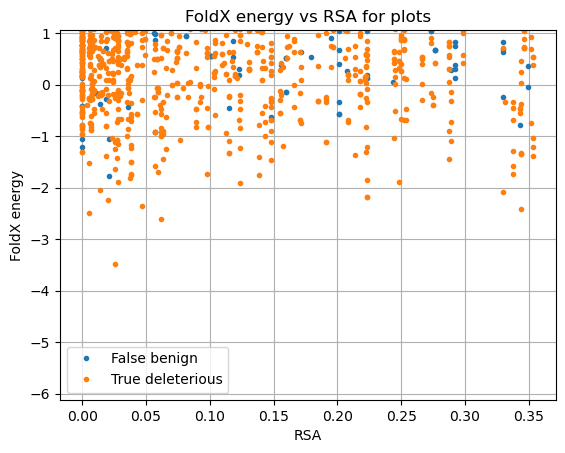

In [33]:
plt.plot(false_benign[0],false_benign[1],'.',label='False benign')
plt.plot(true_deleterious[0],true_deleterious[1],'.',label='True deleterious')
plt.ylim(None,1.06)

plt.xlabel("RSA")
plt.ylabel("FoldX energy")
plt.title("FoldX energy vs RSA for plots")
plt.grid()
plt.legend()

I've set the y limit to 1.06 kcal/mol. Because that's what we determined to be the best threshold for the FoldX values. Despite this, we can clearly see that there are lots of deleterious mutations with a low FoldX energy. Because the FoldX energy is not the only predictor of deleteriousness. RSA is also a good predictor of this.

What does this mean? Perhaps the two need to be used together. Maybe their product. Maybe a dual binary classification.

### What next?
I want to look at combining my parameters to hopefully get better predictions.